# Ensemble bitwise information content

In [1]:
using FileIO, NetCDF, BitInformation
using PyPlot
using ColorSchemes
using StatsBase, Statistics
GS = matplotlib.gridspec
ticker = matplotlib.ticker
patches = matplotlib.patches;

In [2]:
# Load one 3D chunk of temperature data
path = "/network/aopp/chaos/pred/kloewer/esowc/"
member1files = filter(x->endswith(x,".nc"),readdir(joinpath(path,"member1")))
steps = [parse(Int,split(split(file,"step")[2],".")[1]) for file in member1files]
sort!(steps)

ncfile = NetCDF.open(joinpath(path,"member1","ensemble.t.member1.step0.ll.nc"))
temp = ncfile.vars["t"][:,:,:];

# Lon, lat, vert information

In [3]:
bi_lon = bitinformation(temp,dims=1)
bi_lat = bitinformation(temp,dims=2)
bi_vert = bitinformation(temp,dims=3)

32-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.6487237531785313
 0.6570582777415671
 0.533995839047674
 0.41803123970246814
 0.21711636929577316
 ⋮
 1.1024411258331313e-6
 2.4882730864650426e-7
 3.066419018704636e-8
 2.8357480807983393e-9
 3.0073655787887787e-9
 1.1258041388018114e-8
 8.588407152121391e-9
 6.432460053495959e-8
 9.829426256269258e-8
 1.4073192611263607e-8
 8.073035662192751e-8
 7.537781510080777e-10

# Time information

In [4]:
Nlon = 1800
Nlat = 901
Nvert = 91
Ntsteps = length(steps[1:91])   # use only 1hourly data from day 0 to 3.75

# subsample in lat & vertical
temp = Array{Float32,4}(undef,Ntsteps,Nlon,1+Nlat÷2,1+Nvert÷4)

for itime in 1:Ntsteps
    s = steps[itime]
    ncfile = NetCDF.open(joinpath(path,"member1","ensemble.t.member1.step$s.ll.nc"))
    temp[itime,:,:,:] = ncfile.vars["t"][:,1:2:end,1:4:end]
end

In [5]:
bi_time = bitinformation(temp,dims=1);

### Post processing

In [6]:
function remove_false_information!(b::AbstractVector)
    inf_thresh = 1.1*maximum(b[end-7:end])
    b[b .< inf_thresh] .= 0
end

remove_false_information! (generic function with 1 method)

In [7]:
bi_lon_filt = copy(bi_lon)
bi_lat_filt = copy(bi_lat)
bi_vert_filt = copy(bi_vert)
bi_time_filt = copy(bi_time)

remove_false_information!(bi_lon_filt)
remove_false_information!(bi_lat_filt)
remove_false_information!(bi_time_filt)
remove_false_information!(bi_vert_filt);

In [8]:
path = "/network/aopp/chaos/pred/kloewer/esowc/analysis/";
BI = load(joinpath(path,"bitinformation_25members.jld2"),"BI")

BIfilt = copy(BI)

for i in 1:size(BIfilt)[1]
    @views remove_false_information!(BIfilt[i,:])
end

In [9]:
bitvec = collect(1:32)
timevec1 = collect(0:90) / 24       # in days, hourly
timevec2 = collect(93:3:144) / 24   # 3-hourly
timevec3 = collect(150:6:360) / 24; # 6-hourly
timevec = vcat(timevec1,timevec2,timevec3);

In [10]:
ntsteps = size(BI)[1]

# bits preserving p amount of information
p = 99
bits_with_99information = [argmax(cumsum(BIfilt[t,:]) .> (p/100)*sum(BIfilt[t,:])) for t in 1:ntsteps]
# same in the other dimensions
b99inf_lon = argmax(cumsum(bi_lon_filt) .> (p/100)*sum(bi_lon_filt))
b99inf_lat = argmax(cumsum(bi_lat_filt) .> (p/100)*sum(bi_lat_filt))
b99inf_vert = argmax(cumsum(bi_vert_filt) .> (p/100)*sum(bi_vert_filt))
b99inf_time = argmax(cumsum(bi_time_filt) .> (p/100)*sum(bi_time_filt))

# bits preserving p amount of information
p = 99.999999
bits_with_100information = [argmax(cumsum(BIfilt[t,:]) .>= (p/100)*sum(BIfilt[t,:])) for t in 1:ntsteps]
# same in the other dimensions
b100inf_lon = argmax(cumsum(bi_lon_filt) .>= (p/100)*sum(bi_lon_filt))
b100inf_lat = argmax(cumsum(bi_lat_filt) .>= (p/100)*sum(bi_lat_filt))
b100inf_vert = argmax(cumsum(bi_vert_filt) .>= (p/100)*sum(bi_vert_filt))
b100inf_time = argmax(cumsum(bi_time_filt) .>= (p/100)*sum(bi_time_filt));

In [11]:
# mask true zeros for plotting
bi_lon_filt[iszero.(bi_lon)] .= NaN
bi_lat_filt[iszero.(bi_lat)] .= NaN
bi_vert_filt[iszero.(bi_vert)] .= NaN
bi_time_filt[iszero.(bi_time)] .= NaN
BIfilt[iszero.(BI)] .= NaN;

## PLOTTING

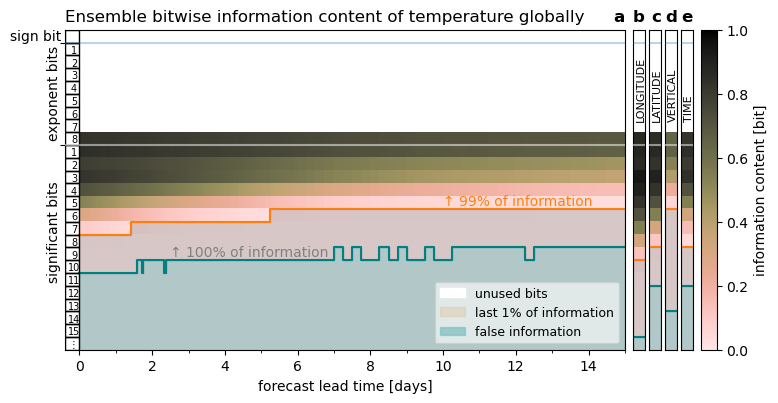

In [14]:
fig = figure(figsize=(8,4))

xmax = .7
ax1 = fig.add_axes([0.1,0.1,xmax,.8])

# for time,lon,lat,vert information
ax4a = fig.add_axes([0.11+xmax,0.1,0.015,.8])
ax4b = fig.add_axes([0.13+xmax,0.1,0.015,.8])
ax4c = fig.add_axes([0.15+xmax,0.1,0.015,.8])
ax4d = fig.add_axes([0.17+xmax,0.1,0.015,.8])

pos = ax4d.get_position()
cax = fig.add_axes([pos.x1+0.01,pos.y0,0.02,pos.y1-pos.y0])
ax1.invert_yaxis()

# information
cmap = ColorMap(ColorSchemes.turku.colors).reversed()
cmap_array = cmap(0:1/100000:1)
cmap_array[1,:] = [1,1,1,1]

pcm = ax1.pcolormesh(timevec,bitvec .- 0.5,BIfilt',vmin=0,vmax=1;cmap)
cbar = colorbar(pcm,cax=cax,orientation="vertical")
cbar.set_label("information content [bit]")

for ax in [ax1,ax4a,ax4b,ax4c,ax4d]
    ax.axhline(1.5,alpha=.3,lw=1.5,zorder=10)
    ax.axhline(9.5,alpha=.5,lw=1.5,color="w",zorder=10)
end

ax4a.pcolormesh([0,1],bitvec .- 0.5,bi_lon_filt[:,:],vmin=0,vmax=1;cmap)
ax4b.pcolormesh([0,1],bitvec .- 0.5,bi_lat_filt[:,:],vmin=0,vmax=1;cmap)
ax4c.pcolormesh([0,1],bitvec .- 0.5,bi_vert_filt[:,:],vmin=0,vmax=1;cmap)
ax4d.pcolormesh([0,1],bitvec .- 0.5,bi_time_filt[:,:],vmin=0,vmax=1;cmap)

# only for legend
ax1.fill_between([0,0],[0,0],color="w",label="unused bits")
ax1.fill_betweenx([-1,-1],[-1,-1],[-1,-1],color="burlywood",label="last 1% of information",alpha=.3)
ax1.fill_betweenx([-1,-1],[-1,-1],[-1,-1],facecolor="teal",edgecolor="c",label="false information",alpha=.3)

# total information
ax1.fill_between(timevec,0.5 .+ bits_with_100information,0.5 .+ bits_with_99information,
                color="grey",alpha=0.3,step="post")
ax1.fill_between(timevec,32*ones(ntsteps),0.5 .+ bits_with_100information,
                color="teal",alpha=0.3,step="post")

ax1.plot(timevec,0.5 .+ bits_with_99information,"C1",ds="steps-post")
ax1.plot(timevec,0.5 .+ bits_with_100information,"teal",ds="steps-post")

ax4a.axhline(b99inf_lon+0.5,color="C1")
ax4b.axhline(b99inf_lat+0.5,color="C1")
ax4c.axhline(b99inf_vert+0.5,color="C1")
ax4d.axhline(b99inf_time+0.5,color="C1")

ax4a.axhline(b100inf_lon+0.5,color="teal")
ax4b.axhline(b100inf_lat+0.5,color="teal")
ax4c.axhline(b100inf_vert+0.5,color="teal")
ax4d.axhline(b100inf_time+0.5,color="teal")

ax4a.fill_between([0,1],0.5 .+ [b100inf_lon,b100inf_lon],0.5 .+ [b99inf_lon,b99inf_lon],color="grey",alpha=0.3)
ax4b.fill_between([0,1],0.5 .+ [b100inf_lat,b100inf_lat],0.5 .+ [b99inf_lat,b99inf_lat],color="grey",alpha=0.3)
ax4c.fill_between([0,1],0.5 .+ [b100inf_vert,b100inf_vert],0.5 .+ [b99inf_vert,b99inf_vert],color="grey",alpha=0.3)
ax4d.fill_between([0,1],0.5 .+ [b100inf_time,b100inf_time],0.5 .+ [b99inf_time,b99inf_time],color="grey",alpha=0.3)

ax4a.fill_between([0,1],[32,32],0.5 .+ [b100inf_lon,b100inf_lon],color="teal",alpha=0.3)
ax4b.fill_between([0,1],[32,32],0.5 .+ [b100inf_lat,b100inf_lat],color="teal",alpha=0.3)
ax4c.fill_between([0,1],[32,32],0.5 .+ [b100inf_vert,b100inf_vert],color="teal",alpha=0.3)
ax4d.fill_between([0,1],[32,32],0.5 .+ [b100inf_time,b100inf_time],color="teal",alpha=0.3)

# show bits
ymax = 25
ax1.add_patch(patches.Rectangle((-.4,.5),.4,1,edgecolor="k",fill=false))
for y in bitvec[2:ymax]
    ax1.add_patch(patches.Rectangle((-.4,y-.5),.4,1,edgecolor="k",fill=false,zorder=10))
    
    if y < 10
        bit_string = string(y-1)
    elseif y < ymax
        bit_string = string(y-9)
    else
        bit_string = "⋮"
    end
    
    ax1.text(-.15,y+.1,bit_string,fontsize=7,ha="center",va="center")
end

ax1.set_title("Ensemble bitwise information content of temperature globally",loc="left")
ax4a.text(0.65,7.5,"LONGITUDE",rotation=90,ha="center",fontsize=8)
ax4b.text(0.65,7.5,"LATITUDE",rotation=90,ha="center",fontsize=8)
ax4c.text(0.65,7.5,"VERTICAL",rotation=90,ha="center",fontsize=8)
ax4d.text(0.65,7.5,"TIME",rotation=90,ha="center",fontsize=8)

for (iax,ax) in enumerate([ax1,ax4a,ax4b,ax4c,ax4d])
    ax.set_title(string(Char(96+iax)),loc="right",fontweight="bold")
end

ax1.legend(loc=4,fontsize=9,framealpha=.6)

for ax in [ax4a,ax4b,ax4c,ax4d]
    ax.set_yticks([])
    ax.set_xticks([])
end

ax1.set_xlim(-.4,360/24)

for ax in [ax1,ax4a,ax4b,ax4c,ax4d]
    ax.set_ylim(ymax+.5,0.5)
end

ax1.set_yticks([1.5,9.5])
ax1.set_yticklabels([])
ax1.set_xlabel("forecast lead time [days]")
ax1.set_xticks(1:15,minor=true)

ax1.text(-0.5,1.3,"sign bit",ha="right")
ax1.text(-0.5,8.9,"exponent bits",rotation=90,ha="right")
ax1.text(-0.5,20,"significant bits",rotation=90,ha="right")

ax1.text(10,14.2,"↑ 99% of information",color="C1")
ax1.text(2.5,18.2,"↑ 100% of information",color="grey")

savefig("../plots/ensemble_information2.png")